In [1]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from scipy.stats import linregress
from matplotlib import pyplot as plt

## Prepare the data

In [2]:
##GG web site data
bronze_df = pd.read_csv("gg_datafiles/bronze.csv", encoding="utf-8")
gold_df = pd.read_csv("gg_datafiles/gold.csv", encoding="utf-8")
platinum_df = pd.read_csv("gg_datafiles/platinum.csv", encoding="utf-8")
platinumplus_df = pd.read_csv("gg_datafiles/platinumplus.csv", encoding="utf-8")
silver_df = pd.read_csv("gg_datafiles/silver.csv", encoding="utf-8")
#####2018-2020
champions_df = pd.read_csv("2018_2020_data/champion.csv", encoding="utf-8")
players_df = pd.read_csv("2018_2020_data/players.csv", encoding="utf-8")
teams_df = pd.read_csv("2018_2020_data/teams.csv", encoding="utf-8")

In [3]:
#Create a new column to specify the league for stacking the dataset
bronze_df["League"] = "Bronze"
gold_df["League"] = "Gold"
platinum_df["League"] = "Platinum"
platinumplus_df["League"] = "Platinum Plus"
silver_df["League"] = "Silver"

#Create stacked combined dataset
stack_df = pd.concat([bronze_df, 
                      gold_df, 
                      platinum_df, 
                      platinumplus_df,
                      silver_df], axis = 0)

## Explore the data
### Describe the dataset

In [4]:
#Columns in the dataset
stack_df.columns

#Search for null values, number of non-null values, data types
stack_df.info()

#Identify Null Values
df_null = stack_df[stack_df.isnull().any(axis=1)]

#Drop weird rows with no Champion listed & check non-null values
df2 = stack_df.dropna(subset = ['Champion'])
df2.info()

## === Notice that playerbase avg games still has less data (898) === ##

#Percentage values showing up as OBJECTS, 
#problematic, need to remove the % for calculations!
champ_df = df2.groupby(["Champion"]).mean()
champ_df.head()

## === Notice there are NO stats for these metrics ==== ##

#Create a function to convert percent to float
def convert_percent(val):
    """
    Convert the percentage string to an actual floating point percent
    - Remove %
    - Divide by 100 to make decimal
    """
    new_val = val.replace('%', '')
    return float(new_val) / 100

# Created a new column that applies the function to convert percentage to float
# See below for alternative method that did NOT work, I am not sure why though

df2['win_percent'] = df2["Win Percent"].apply(convert_percent)
df2['ban_rate'] = df2["Ban Rate"].apply(convert_percent)
df2['play_percent'] = df2["Play Percent"].apply(convert_percent)

# Drop extra columns
df2.drop(columns=['Win Percent', 'Play Percent', 'Ban Rate'])

# Attempted to convert this way but didn't change the values from objects to floats for some reason
# df2['Win Percent'].apply(lambda x: x.replace('%', '')).astype('float') / 100
# df2['Play Percent'].apply(lambda x: x.replace('%', '')).astype('float') / 100
# df2['Ban Rate'].apply(lambda x: x.replace('%', '')).astype('float') / 100
# df2.dtypes

#Reorder columns
df2.columns
df2 = df2.reindex(columns = ['Rank', 'Champion', 'Role', 'League',
       'win_percent', 'ban_rate', 'play_percent',
       'Playerbase Avg. Games', 'Kills', 'Deaths', 'Assists',
       'Largest Killing Spree', 'Damage Dealt', 'Damage Taken',
       'Total Healing', 'Minions Killed', 'Enemy Jungle CS', 'Team Jungle CS',
       'Gold Earned', 'Role Position', 'Position Change'])
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 187
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rank                   989 non-null    object 
 1   Champion               979 non-null    object 
 2   Role                   979 non-null    object 
 3   Win Percent            979 non-null    object 
 4   Play Percent           979 non-null    object 
 5   Ban Rate               979 non-null    object 
 6   Playerbase Avg. Games  898 non-null    float64
 7   Kills                  979 non-null    float64
 8   Deaths                 979 non-null    float64
 9   Assists                979 non-null    float64
 10  Largest Killing Spree  979 non-null    float64
 11  Damage Dealt           979 non-null    float64
 12  Damage Taken           979 non-null    float64
 13  Total Healing          979 non-null    float64
 14  Minions Killed         979 non-null    float64
 15  Enemy 

C:\anaconda\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\anaconda\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\anaconda\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,Rank,Champion,Role,League,win_percent,ban_rate,play_percent,Playerbase Avg. Games,Kills,Deaths,...,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change
0,1,Aatrox,Top,Bronze,0.4690,0.0042,0.0206,2.58,5.49,5.90,...,7.0,18687.0,31430.0,12450.0,146.8,2.52,3.66,10685.0,35.0,1.0
1,2,Ahri,Middle,Bronze,0.5184,0.0030,0.0333,2.91,6.82,5.69,...,7.0,20593.0,18989.0,3499.0,140.2,0.85,2.83,10769.0,20.0,3.0
2,3,Akali,Middle,Bronze,0.4379,0.0077,0.0349,2.98,8.45,6.61,...,10.0,19250.0,25051.0,6740.0,133.9,1.16,2.28,10933.0,40.0,2.0
3,4,Akali,Top,Bronze,0.4667,0.0077,0.0127,3.98,7.21,6.06,...,7.0,19055.0,24429.0,6704.0,145.3,1.18,1.71,10718.0,40.0,0.0
4,5,Alistar,Support,Bronze,0.5176,0.0007,0.0243,2.41,2.02,5.84,...,4.0,7948.0,21527.0,9162.0,30.8,0.10,0.13,7501.0,22.0,6.0


In [5]:
#Explore Unique Values in the Dataset
ind_list = []
unique_count = []
for col in df2.columns:
    ind_list.append(col)
    unique_count.append(len(df2[col].unique()))
final_series = pd.DataFrame({'Feature':ind_list,'Unique values':unique_count}).sort_values(by='Unique values',ascending=True).reset_index(drop=True).style.bar()
final_series

,Feature,Unique values
0,Role,5
1,League,5
2,Largest Killing Spree,10
3,Position Change,21
4,Role Position,71
5,Champion,148
6,ban_rate,215
7,Rank,232
8,Deaths,287
9,play_percent,470


In [6]:
#Number of unique champions per league
league_df_champ = df2.groupby(["League"]).nunique()["Champion"]
league_df_champ

League
Bronze           148
Gold             140
Platinum         146
Platinum Plus    148
Silver           146
Name: Champion, dtype: int64

In [7]:
#Number of Roles
league_df_role = df2.groupby(["League"]).nunique()["Role"]
league_df_role

League
Bronze           5
Gold             5
Platinum         5
Platinum Plus    5
Silver           5
Name: Role, dtype: int64

In [8]:
league_df_champ_role = df2.groupby(["League", "Champion"]).nunique()["Role"]
league_df_champ_role

League  Champion
Bronze  Aatrox      1
        Ahri        1
        Akali       2
        Alistar     1
        Amumu       1
                   ..
Silver  Zed         1
        Ziggs       1
        Zilean      1
        Zoe         1
        Zyra        1
Name: Role, Length: 728, dtype: int64

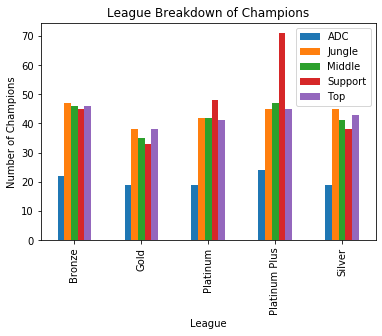

In [9]:
#Create a graph that shows the number of Champions per Role with League as the X axis
role_chart = df2.groupby(["League", "Role"]).count()["Rank"].unstack().plot(kind = "bar")
role_chart.set_ylabel("Number of Champions")
plt.title("League Breakdown of Champions")
plt.legend(loc="best")
plt.show()

## Support Role Analysis

* High total healing (G)

* High damage taken (G)

* High minion kills (G)

* Low death (G)

* High assist (G)

In [10]:
#Create new data frame with just support role
support = df2.loc[df2["Role"] == "Support"][["Rank", "Champion", "League", 'Total Healing', 'Damage Taken', 'Minions Killed', "Deaths", 'Assists']]
support.head()

,Rank,Champion,League,Total Healing,Damage Taken,Minions Killed,Deaths,Assists
4,5,Alistar,Bronze,9162.0,21527.0,30.8,5.84,12.80
7,8,Anivia,Bronze,1957.0,15847.0,65.4,4.27,6.87
9,10,Annie,Bronze,1004.0,12361.0,53.6,5.63,6.48
14,15,Bard,Bronze,6428.0,17262.0,32.2,5.58,12.44
15,16,Blitzcrank,Bronze,1766.0,18730.0,29.6,5.82,11.62


In [11]:
#groupby Champion - merges League
champ_support = support.groupby("Champion").mean()
champ_support

,Total Healing,Damage Taken,Minions Killed,Deaths,Assists
Champion,,,,,
Aatrox,4177.0,12953.500000,102.900000,3.025,2.180000
Ahri,1232.0,8987.000000,90.900000,3.280,4.010000
Akali,2051.5,10812.000000,98.150000,3.355,1.990000
Alistar,8914.2,20848.200000,30.640000,5.650,12.508000
Anivia,1792.5,14892.500000,71.100000,3.995,6.275000
...,...,...,...,...,...
Yuumi,13246.4,7466.800000,7.020000,3.762,14.410000
Ziggs,941.0,11687.000000,71.200000,4.990,6.690000
Zilean,5469.4,14440.800000,39.960000,4.900,11.482000


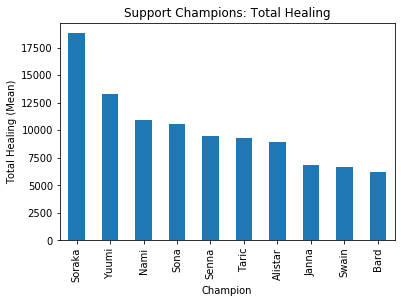

In [12]:
#Bar chart for healing
healing = champ_support.sort_values(["Total Healing"],ascending=False)["Total Healing"]
healing_graph = healing.head(10).plot(kind="bar")
healing_graph.set_ylabel("Total Healing (Mean)")
plt.title("Support Champions: Total Healing")
plt.show()

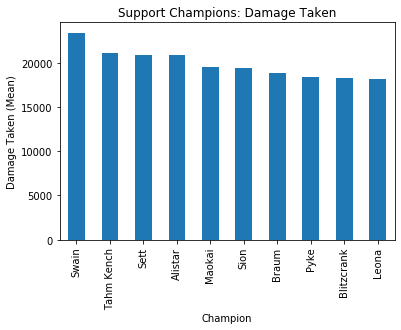

In [13]:
#Bar chart for Damage Taken
damage = champ_support.sort_values(["Damage Taken"],ascending=False)["Damage Taken"]
damage_graph = damage.head(10).plot(kind="bar")
damage_graph.set_ylabel("Damage Taken (Mean)")
plt.title("Support Champions: Damage Taken")
plt.show()

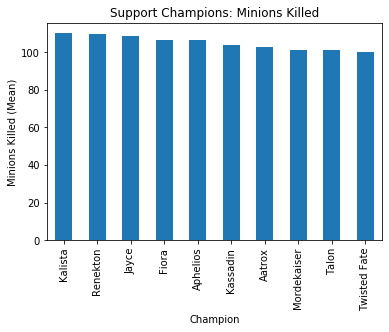

In [14]:
#Bar chart for High Minions Taken
minions = champ_support.sort_values(["Minions Killed"],ascending=False)["Minions Killed"]
minion_graph = minions.head(10).plot(kind="bar")
minion_graph.set_ylabel("Minions Killed (Mean)")
plt.title("Support Champions: Minions Killed")
plt.show()

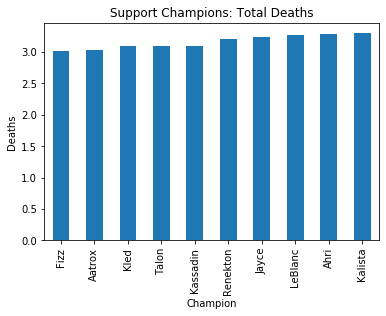

In [15]:
#Bar chart for Deaths Taken
death = champ_support.sort_values(["Deaths"], ascending = True)["Deaths"]
death_graph = death.head(10).plot(kind="bar")
death_graph.set_ylabel("Deaths")
plt.title("Support Champions: Total Deaths")
plt.show()

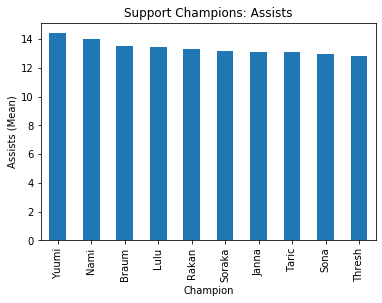

In [16]:
#Bar chart for Assist
assist = champ_support.sort_values(["Assists"],ascending=False)["Assists"]
minion_graph = assist.head(10).plot(kind="bar")
minion_graph.set_ylabel("Assists (Mean)")
plt.title("Support Champions: Assists")
plt.show()

# Correlation Analysis

## Pairplot analysis of Metrics (subset) to help determine best champions for each role

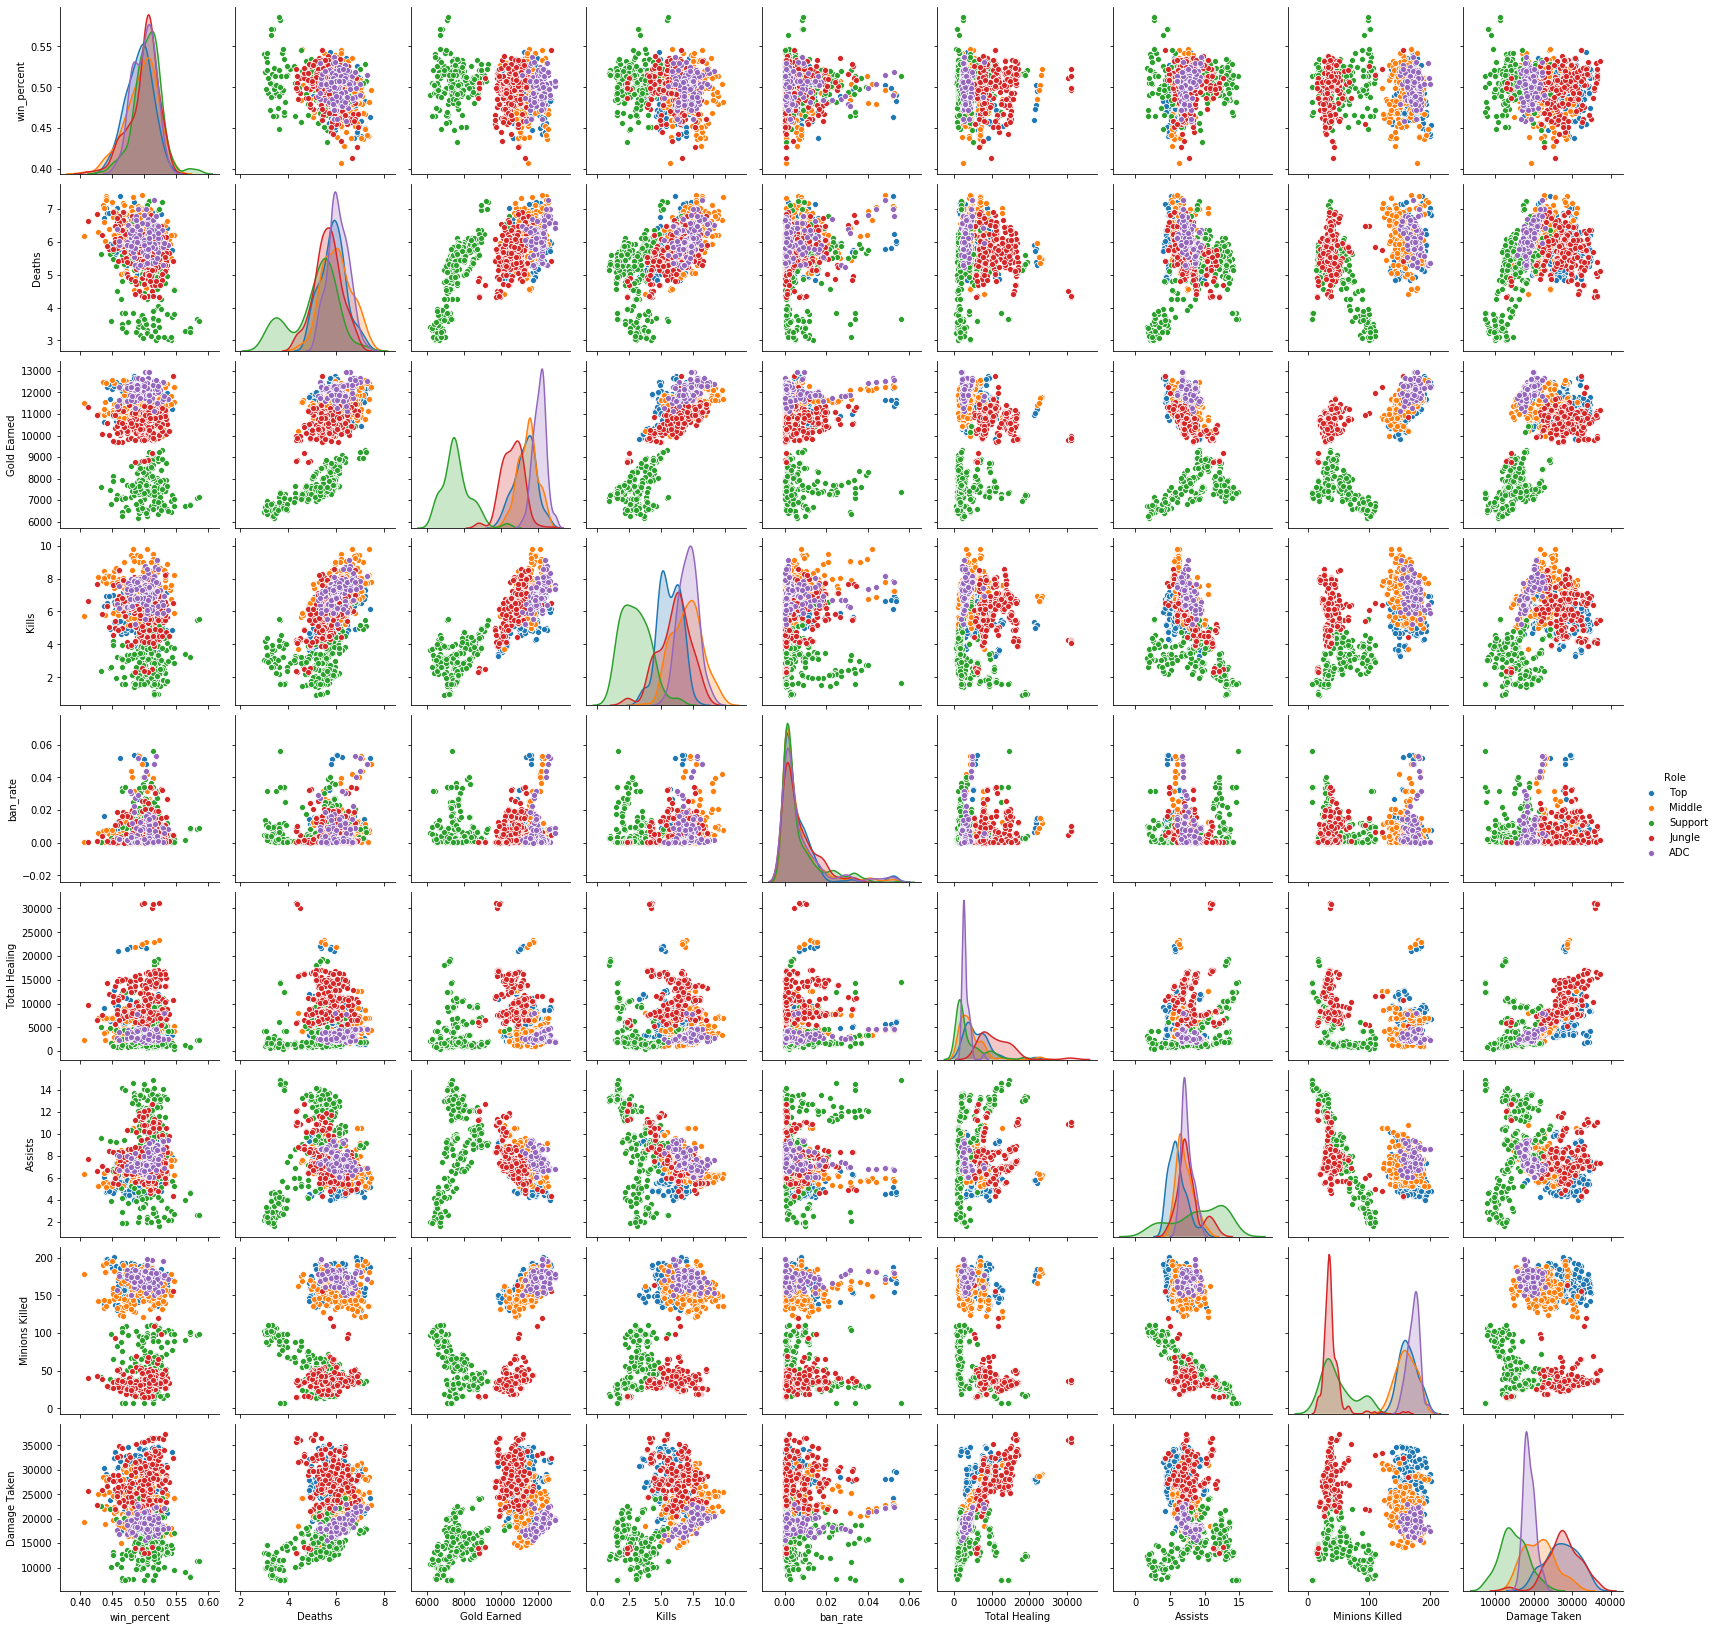

In [52]:
#What we most care about is the win_percent correlation analysis (first column)
df3 = df2[["win_percent", "Role", "Deaths", "Gold Earned", "Kills", "ban_rate", "Total Healing", "Assists", "Minions Killed", "Damage Taken"]]
sns.pairplot(df3, hue="Role")

In [18]:
# Correlation analysis 
# Continued below with heatmaps for a visual representation
df2.corr().sort_values("win_percent", ascending=False)

,win_percent,ban_rate,play_percent,Playerbase Avg. Games,Kills,Deaths,Assists,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change
win_percent,1.000000,-0.005536,0.074383,0.193339,-0.163482,-0.313124,0.167246,-0.149775,-0.130749,-0.132912,-0.042907,-0.137264,-0.010035,0.011130,-0.167595,-0.429808,0.117937
Playerbase Avg. Games,0.193339,-0.159314,-0.076370,1.000000,0.008127,-0.043573,-0.001022,-0.044614,0.046020,0.060922,0.013072,0.045864,0.123119,0.088063,0.090861,-0.063430,0.022459
Assists,0.167246,-0.079953,0.260874,-0.001022,-0.539509,-0.034318,1.000000,-0.379033,-0.386024,-0.229634,0.080424,-0.493803,-0.194864,0.000891,-0.382188,-0.158185,-0.041355
Position Change,0.117937,-0.155120,-0.144379,0.022459,-0.100648,-0.129240,-0.041355,-0.125738,-0.068169,-0.028556,0.002631,-0.032447,0.001329,0.007344,-0.109378,0.097975,1.000000
play_percent,0.074383,0.459707,1.000000,-0.076370,0.044148,0.068151,0.260874,0.223049,-0.079294,-0.037693,0.069884,-0.127001,0.066001,0.086804,0.066669,-0.564827,-0.144379
Team Jungle CS,0.011130,-0.008432,0.086804,0.088063,0.198875,-0.003833,0.000891,0.213247,-0.141207,0.467038,0.578294,-0.546457,0.915114,1.000000,0.138849,-0.020586,0.007344
ban_rate,-0.005536,1.000000,0.459707,-0.159314,0.116228,0.116353,-0.079953,0.155158,-0.030767,0.052348,0.063311,-0.009039,0.025211,-0.008432,0.046162,-0.434719,-0.155120
Enemy Jungle CS,-0.010035,0.025211,0.066001,0.123119,0.360650,0.114639,-0.194864,0.331616,0.022853,0.554940,0.550567,-0.331294,1.000000,0.915114,0.340177,-0.085563,0.001329
Total Healing,-0.042907,0.063311,0.069884,0.013072,0.060557,0.013760,0.080424,0.052433,-0.111251,0.604629,1.000000,-0.322803,0.550567,0.578294,0.106868,-0.121171,0.002631
Damage Dealt,-0.130749,-0.030767,-0.079294,0.046020,0.751742,0.563903,-0.386024,0.593013,1.000000,0.279104,-0.111251,0.741225,0.022853,-0.141207,0.837401,-0.288031,-0.068169


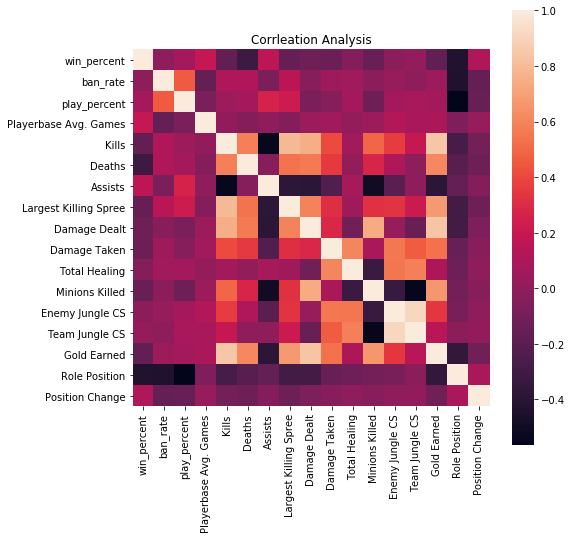

In [19]:
#Correlation Analysis for Complete Data Set
plt.figure(figsize=(8,8))
sns.heatmap(df2.corr(),annot=False,square=True)
plt.title("Corrleation Analysis")
plt.show()

#### Champions
* moderate __negative__ correlation between Deaths and Win Rate (as expected) but also Role Position.

## Analysis of each Champion Role
### Support Champion

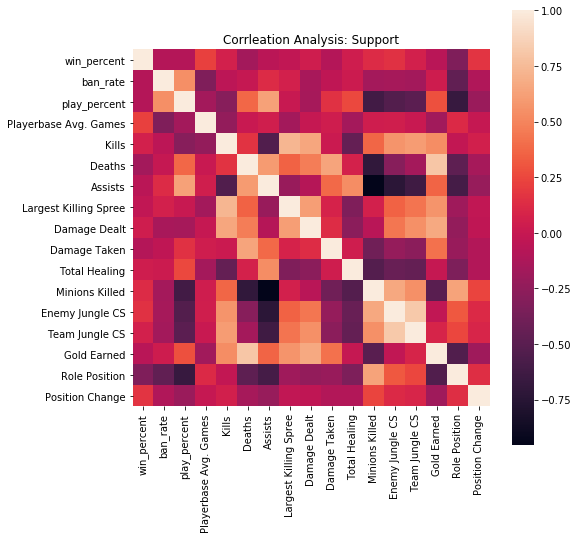

In [20]:
support = df2.loc[df2["Role"] == "Support"]
plt.figure(figsize=(8,8))
sns.heatmap(support.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: Support")
plt.show()

#### Support Champion:
* __weak negative__ correlation between Role Posiion and win_rate for Support Champions
* No other measurements stood out as strongly correlative

### Jungle Champion

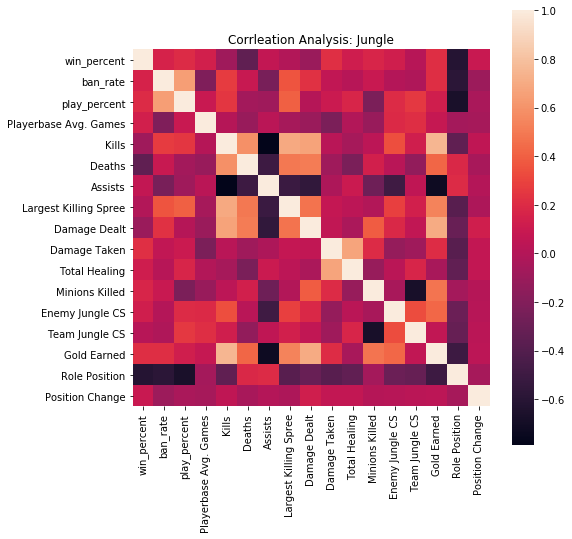

In [21]:
jungle = df2.loc[df2["Role"] == "Jungle"]
plt.figure(figsize=(8,8))
sns.heatmap(jungle.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: Jungle")
plt.show()

#### Jungle Champion:
* __weak positive__ correlation between damage taken, gold earned, percent played with win percent
* __strong negative__ correlation with Role Position and win percent

### Middle Champion

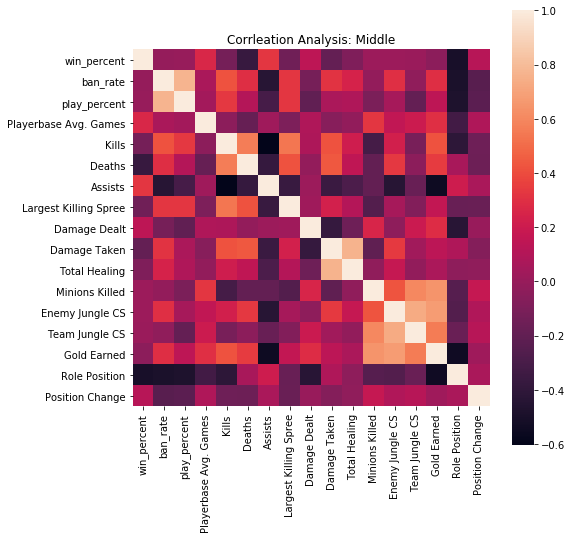

In [22]:
middle = df2.loc[df2["Role"] == "Middle"]
plt.figure(figsize=(8,8))
sns.heatmap(middle.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: Middle")
plt.show()

#### Middle Champion:
* __mild posistive__ correlation between Assists and Win Percent
* __mild negative__ correaltion between Role Position and Win Percent 

### Top Champion

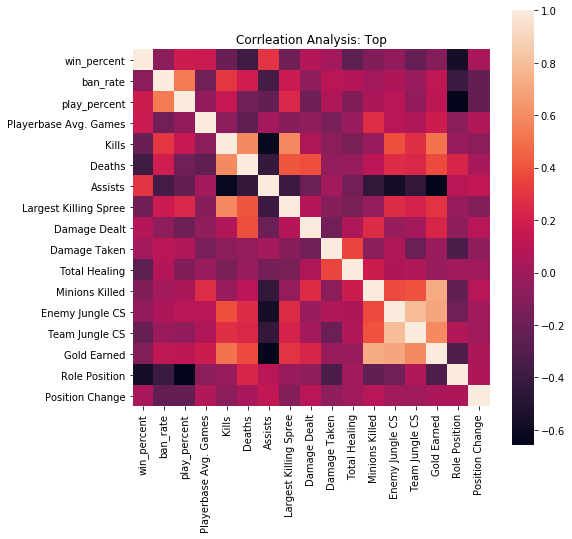

In [23]:
top = df2.loc[df2["Role"] == "Top"]
plt.figure(figsize=(8,8))
sns.heatmap(top.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: Top")
plt.show()

#### Top Champion:
* __mild posistive__ correlation between Assists and win percent
* __mild negative__ correaltion between kills, total healing and win percent
* __strong negative__ correlation between role position and win percent

### ADC Champion

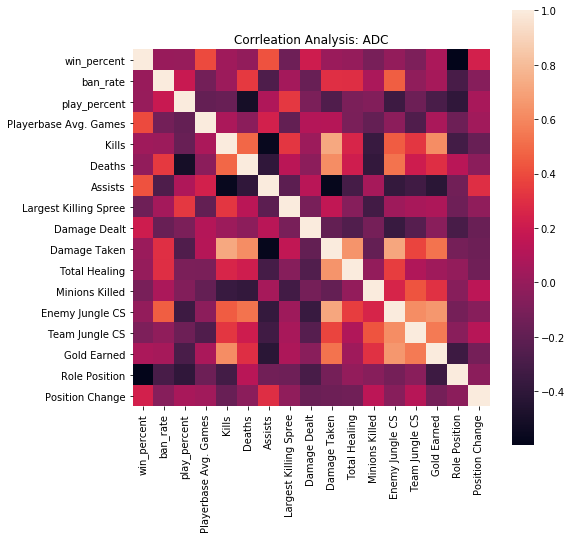

In [24]:
ADC = df2.loc[df2["Role"] == "ADC"]
plt.figure(figsize=(8,8))
sns.heatmap(ADC.corr(),annot=False,square=True)
plt.title("Corrleation Analysis: ADC")
plt.show()

#### ADC Champion:
* __moderate posistive__ correlation between Assists and win percent
* __mild positive__ correaltion between psition change and damage dealt with win percent
* __strong negative__ correlation between role position and win percent

#  Mid Role Analysis

### - High kills (G)
### - Low deaths (G)
### - High assist (G)
### - High minions kills (G)



In [25]:
stack_df.loc[stack_df.Role == "Middle"][["Kills","Deaths","Assists","Minions Killed"]]


,Kills,Deaths,Assists,Minions Killed
1,6.82,5.69,7.73,140.2
2,8.45,6.61,5.48,133.9
6,5.94,4.96,7.49,158.3
8,7.91,6.49,7.80,139.4
12,5.70,5.95,8.82,132.2
...,...,...,...,...
173,6.75,5.02,8.59,162.2
177,7.27,7.02,5.74,176.2
181,9.09,6.41,5.59,158.1
182,5.58,5.55,7.71,170.2


In [26]:
Jim_group = stack_df.loc[stack_df.Role == "Middle"].groupby("Champion")[["Kills","Deaths","Assists","Minions Killed"]].mean()
Jim_group.head()

,Kills,Deaths,Assists,Minions Killed
Champion,,,,
Ahri,6.6500,5.490,7.6720,153.360
Akali,8.1620,6.326,5.3820,144.940
Anivia,5.8300,4.665,7.5025,170.500
Annie,7.6000,6.200,7.6060,150.940
Aurelion Sol,5.7125,5.590,8.6950,145.425


In [27]:
kills_df = Jim_group.sort_values("Kills",ascending=False)[["Kills"]].head(10)
kills_df

,Kills
Champion,
Katarina,9.466
Zed,9.216
Fizz,8.842
Talon,8.828
Nocturne,8.405
Qiyana,8.356
Akali,8.162
Kassadin,8.070
Irelia,7.918


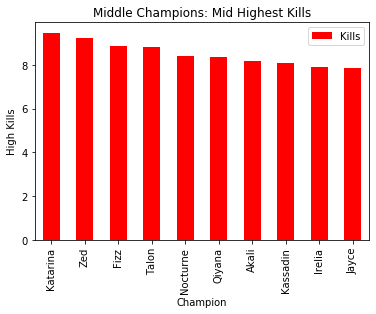

In [28]:
kills_graph = kills_df.plot(kind="bar", color="red")
kills_graph.set_ylabel("High Kills")

plt.title("Middle Champions: Mid Highest Kills")
#plt.grid()
plt.show()

In [29]:
low_deaths_df = Jim_group.sort_values("Deaths")[["Deaths"]].head(10)
low_deaths_df

,Deaths
Champion,
Zilean,4.420
Anivia,4.665
Xerath,5.044
LeBlanc,5.188
Lux,5.314
Orianna,5.406
Galio,5.440
Ahri,5.490
Malzahar,5.548


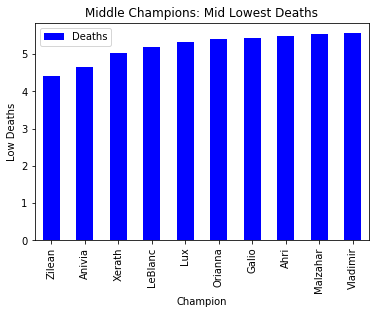

In [30]:
low_deaths_graph = low_deaths_df.plot(kind="bar",color="blue")
low_deaths_graph.set_ylabel("Low Deaths")
plt.title("Middle Champions: Mid Lowest Deaths")
#plt.grid()
plt.show()

In [31]:
high_assists_df = Jim_group.sort_values("Assists",ascending=False)[["Assists"]].head(10)
high_assists_df

,Assists
Champion,
Zilean,10.780000
Nunu & Willump,10.506667
Galio,9.942000
Orianna,9.336000
Lux,9.242000
Lissandra,8.892000
Karthus,8.873333
Aurelion Sol,8.695000
Xerath,8.652000


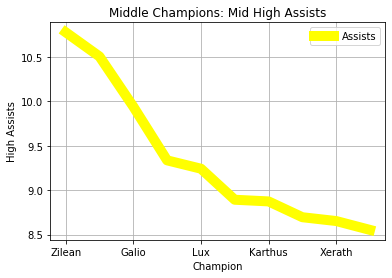

In [32]:
high_assists_graph = high_assists_df.plot(color="yellow",linewidth=10)
high_assists_graph.set_ylabel("High Assists")
plt.title("Middle Champions: Mid High Assists")
plt.grid()
plt.show()

In [33]:
high_minion_killed_df = Jim_group.sort_values("Minions Killed",ascending=False)[["Minions Killed"]].head(10)
high_minion_killed_df

,Minions Killed
Champion,
Irelia,190.30
Malzahar,183.88
Kog'Maw,182.60
Ryze,182.28
Corki,178.64
Yasuo,178.44
Vladimir,177.94
Viktor,176.72
Karthus,176.60


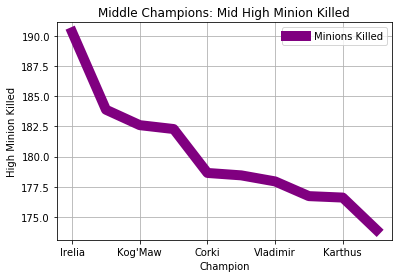

In [34]:
high_minion_killed_graph = high_minion_killed_df.plot(color="purple",linewidth=10)
high_minion_killed_graph.set_ylabel("High Minion Killed")
plt.title("Middle Champions: Mid High Minion Killed")
plt.grid()
plt.show()

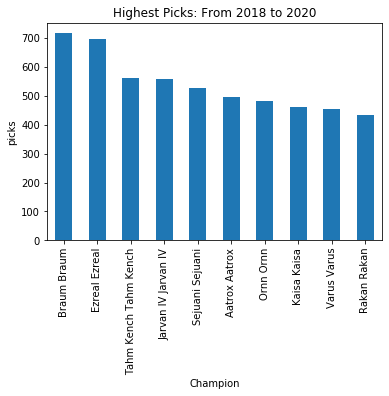

In [35]:
reduced_champions_df = champions_df.groupby(["Champion"]).mean()

#reduced_champions_df.head()
new = reduced_champions_df.sort_values(["picks"],ascending=False)["picks"]
healing_graph = new.head(10).plot(kind="bar")
healing_graph.set_ylabel("picks")
plt.title("Highest Picks: From 2018 to 2020")
plt.show()

# ADC (Attack Damage Carry)

1) High Gold Earned

2) High Damage Taken

3) High Damage Dealt

Note: ADC-is an archaic term used to refer to a champion that deals strong, continuous damage with their basic attacks and scales with attack-related stats - i.e. attack damage, critical strike chance and attack speed.

In [36]:
#Drop columns
drop_df=stack_df.drop(columns=['Win Percent', 'Play Percent', 'Ban Rate'])
drop_df.head()

,Rank,Champion,Role,Playerbase Avg. Games,Kills,Deaths,Assists,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change,League
0,1,Aatrox,Top,2.58,5.49,5.90,5.96,7.0,18687.0,31430.0,12450.0,146.8,2.52,3.66,10685.0,35.0,1.0,Bronze
1,2,Ahri,Middle,2.91,6.82,5.69,7.73,7.0,20593.0,18989.0,3499.0,140.2,0.85,2.83,10769.0,20.0,3.0,Bronze
2,3,Akali,Middle,2.98,8.45,6.61,5.48,10.0,19250.0,25051.0,6740.0,133.9,1.16,2.28,10933.0,40.0,2.0,Bronze
3,4,Akali,Top,3.98,7.21,6.06,4.82,7.0,19055.0,24429.0,6704.0,145.3,1.18,1.71,10718.0,40.0,0.0,Bronze
4,5,Alistar,Support,2.41,2.02,5.84,12.80,4.0,7948.0,21527.0,9162.0,30.8,0.10,0.13,7501.0,22.0,6.0,Bronze


In [37]:
#Drop NaN 
clean_df=drop_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
clean_df

,Rank,Champion,Role,Playerbase Avg. Games,Kills,Deaths,Assists,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change,League
0,1,Aatrox,Top,2.58,5.49,5.90,5.96,7.0,18687.0,31430.0,12450.0,146.8,2.52,3.66,10685.0,35.0,1.0,Bronze
1,2,Ahri,Middle,2.91,6.82,5.69,7.73,7.0,20593.0,18989.0,3499.0,140.2,0.85,2.83,10769.0,20.0,3.0,Bronze
2,3,Akali,Middle,2.98,8.45,6.61,5.48,10.0,19250.0,25051.0,6740.0,133.9,1.16,2.28,10933.0,40.0,2.0,Bronze
3,4,Akali,Top,3.98,7.21,6.06,4.82,7.0,19055.0,24429.0,6704.0,145.3,1.18,1.71,10718.0,40.0,0.0,Bronze
4,5,Alistar,Support,2.41,2.02,5.84,12.80,4.0,7948.0,21527.0,9162.0,30.8,0.10,0.13,7501.0,22.0,6.0,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,181,Zac,Jungle,2.91,4.10,4.35,11.02,7.0,13134.0,36498.0,31025.0,37.0,5.19,74.17,9894.0,7.0,0.0,Silver
181,182,Zed,Middle,2.76,9.09,6.41,5.59,9.0,22524.0,21230.0,3175.0,158.1,1.90,3.69,12116.0,1.0,0.0,Silver
182,183,Ziggs,Middle,2.81,5.58,5.55,7.71,8.0,25282.0,16238.0,1347.0,170.2,1.47,5.08,11412.0,27.0,0.0,Silver
183,184,Zilean,Support,3.05,2.57,5.03,11.44,4.0,11799.0,15014.0,5666.0,41.8,0.36,0.53,8124.0,19.0,0.0,Silver


In [38]:
#Reorganize column index
clean_df.columns
clean_df = clean_df.reindex(columns = ['Rank', 'Champion', 'Role', 'League',
        'Gold Earned','Damage Dealt','Damage Taken','Playerbase Avg. Games',
        'Kills', 'Deaths', 'Assists','Largest Killing Spree','Total Healing',
        'Minions Killed', 'Enemy Jungle CS', 'Team Jungle CS',
        'Role Position', 'Position Change'])
clean_df.head()

,Rank,Champion,Role,League,Gold Earned,Damage Dealt,Damage Taken,Playerbase Avg. Games,Kills,Deaths,Assists,Largest Killing Spree,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Role Position,Position Change
0,1,Aatrox,Top,Bronze,10685.0,18687.0,31430.0,2.58,5.49,5.90,5.96,7.0,12450.0,146.8,2.52,3.66,35.0,1.0
1,2,Ahri,Middle,Bronze,10769.0,20593.0,18989.0,2.91,6.82,5.69,7.73,7.0,3499.0,140.2,0.85,2.83,20.0,3.0
2,3,Akali,Middle,Bronze,10933.0,19250.0,25051.0,2.98,8.45,6.61,5.48,10.0,6740.0,133.9,1.16,2.28,40.0,2.0
3,4,Akali,Top,Bronze,10718.0,19055.0,24429.0,3.98,7.21,6.06,4.82,7.0,6704.0,145.3,1.18,1.71,40.0,0.0
4,5,Alistar,Support,Bronze,7501.0,7948.0,21527.0,2.41,2.02,5.84,12.80,4.0,9162.0,30.8,0.10,0.13,22.0,6.0


In [39]:
#Use Loc command to look for specific Role and Role's cotribution to team
clean_df.loc[clean_df.Role == "ADC"][["Gold Earned","Damage Taken","Damage Dealt"]]

,Gold Earned,Damage Taken,Damage Dealt
11,11603.0,18654.0,18836.0
19,11828.0,17925.0,20200.0
21,11631.0,22919.0,20655.0
32,12653.0,20348.0,21272.0
37,11602.0,18367.0,22680.0
...,...,...,...
153,12294.0,20115.0,21663.0
157,11886.0,16301.0,21441.0
158,11895.0,20075.0,18698.0
172,12162.0,18357.0,19782.0


In [40]:
# Calculate mean on privious output
champ_grp = clean_df.loc[clean_df.Role == "ADC"].groupby("Champion")[["Gold Earned","Damage Taken","Damage Dealt"]].mean()
champ_grp .head()

,Gold Earned,Damage Taken,Damage Dealt
Champion,,,
Ashe,11667.2,18188.2,18700.8
Caitlyn,11973.6,17594.2,20233.0
Cassiopeia,11727.5,22519.0,20211.0
Draven,12838.8,19857.4,21067.6
Ezreal,11779.0,18233.4,22943.4


In [41]:
#Highest Gold Earned Champion in a Game
gold_df = champ_grp.sort_values("Gold Earned",ascending=False)[["Gold Earned"]].head(5)
gold_df

,Gold Earned
Champion,
Draven,12838.8
Yasuo,12545.6
Kog'Maw,12426.6
Twitch,12395.0
Kalista,12311.2


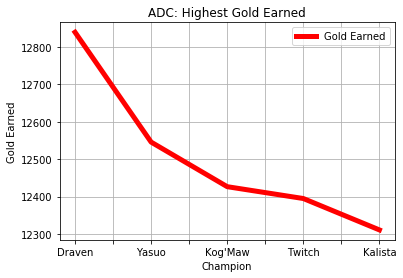

In [42]:
gold_df = gold_df.plot(color="red",linewidth=5)
gold_df.set_ylabel("Gold Earned")
plt.title("ADC: Highest Gold Earned")
plt.grid()
plt.show()

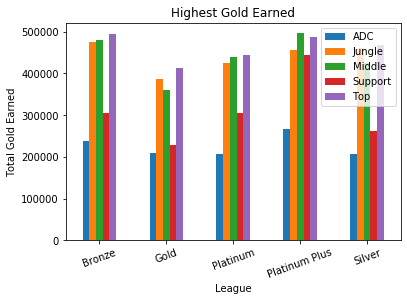

In [43]:
role_chart = clean_df.groupby(["League", "Role"]).sum()["Gold Earned"].unstack().plot(kind = "bar")
role_chart.set_ylabel("Total Gold Earned")
plt.title("Highest Gold Earned")
plt.xticks(rotation=20)
plt.legend(loc="best")
plt.show()

In [44]:
#Highest Damage Taken in a Game
damage_taken = champ_grp.sort_values("Damage Taken",ascending=True)[["Damage Taken"]].head(5)
damage_taken

,Damage Taken
Champion,
Ziggs,16114.5
Varus,16875.4
Syndra,17093.0
Heimerdinger,17108.5
Veigar,17143.0


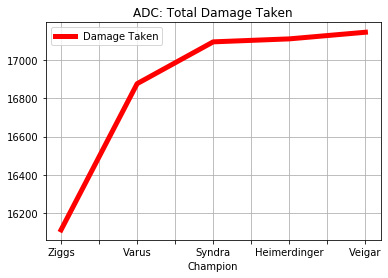

In [45]:
damage_taken_df = damage_taken.plot(color="red",linewidth=5)
gold_df.set_ylabel("Damage Taken")
plt.title("ADC: Total Damage Taken")
plt.grid()
plt.show()

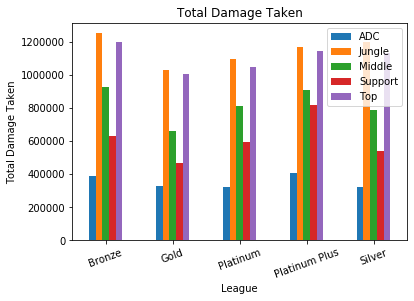

In [46]:

role_chart = clean_df.groupby(["League", "Role"]).sum()["Damage Taken"].unstack().plot(kind = "bar")
role_chart.set_ylabel("Total Damage Taken")
plt.title("Total Damage Taken")
plt.xticks(rotation=20)
plt.legend(loc="best")
plt.show()

In [47]:
#Highest Damage dealt in a Game
damage_dealt = champ_grp.sort_values("Damage Dealt",ascending=False)[["Damage Dealt"]].head(5)
damage_dealt 

,Damage Dealt
Champion,
Ziggs,25139.0
Kog'Maw,25114.6
Heimerdinger,24412.5
Ezreal,22943.4
Twitch,22053.4


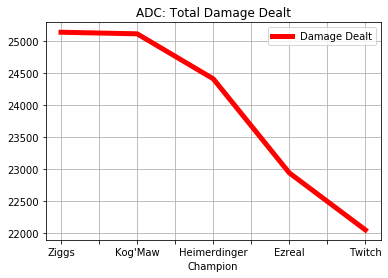

In [48]:
damage_dealt_df = damage_dealt.plot(color="red",linewidth=5)
gold_df.set_ylabel("Damage Dealt")
plt.title("ADC: Total Damage Dealt")
plt.grid()
plt.show()

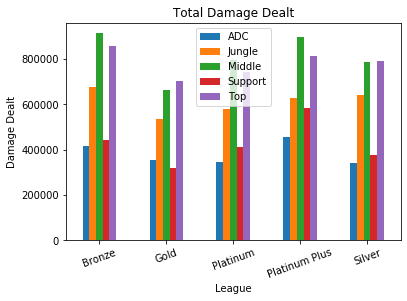

In [49]:
role_chart = clean_df.groupby(["League", "Role"]).sum()["Damage Dealt"].unstack().plot(kind = "bar")
role_chart.set_ylabel("Damage Dealt")
plt.title("Total Damage Dealt")
plt.xticks(rotation=20)
plt.legend(loc="best")
plt.show()

## Finding the SUPER SQUAD!!!!
#### Creating an algorithm to find the most viable champion for each role 

In [50]:
df2.columns
df2 = df2.reindex(columns = ['Rank', 'Champion', 'Role', 'League',
       'win_percent', 'ban_rate', 'play_percent',
       'Playerbase Avg. Games', 'Kills', 'Deaths', 'Assists',
       'Largest Killing Spree', 'Damage Dealt', 'Damage Taken',
       'Total Healing', 'Minions Killed', 'Enemy Jungle CS', 'Team Jungle CS',
       'Gold Earned', 'Role Position', 'Position Change'])
df2.head()

,Rank,Champion,Role,League,win_percent,ban_rate,play_percent,Playerbase Avg. Games,Kills,Deaths,...,Largest Killing Spree,Damage Dealt,Damage Taken,Total Healing,Minions Killed,Enemy Jungle CS,Team Jungle CS,Gold Earned,Role Position,Position Change
0,1,Aatrox,Top,Bronze,0.4690,0.0042,0.0206,2.58,5.49,5.90,...,7.0,18687.0,31430.0,12450.0,146.8,2.52,3.66,10685.0,35.0,1.0
1,2,Ahri,Middle,Bronze,0.5184,0.0030,0.0333,2.91,6.82,5.69,...,7.0,20593.0,18989.0,3499.0,140.2,0.85,2.83,10769.0,20.0,3.0
2,3,Akali,Middle,Bronze,0.4379,0.0077,0.0349,2.98,8.45,6.61,...,10.0,19250.0,25051.0,6740.0,133.9,1.16,2.28,10933.0,40.0,2.0
3,4,Akali,Top,Bronze,0.4667,0.0077,0.0127,3.98,7.21,6.06,...,7.0,19055.0,24429.0,6704.0,145.3,1.18,1.71,10718.0,40.0,0.0
4,5,Alistar,Support,Bronze,0.5176,0.0007,0.0243,2.41,2.02,5.84,...,4.0,7948.0,21527.0,9162.0,30.8,0.10,0.13,7501.0,22.0,6.0


In [51]:
# Creating Jungle dataframe
jungle = df2.loc[df2["Role"] == "Jungle"][["Rank", "Champion", "League", 'Minions Killed', "Enemy Jungle CS", 'Team Jungle CS', "Role Position", "Assists"]]
jungle.head()

,Rank,Champion,League,Minions Killed,Enemy Jungle CS,Team Jungle CS,Role Position,Assists
5,6,Amumu,Bronze,32.4,6.92,76.56,23.0,9.78
23,24,Cho'Gath,Bronze,69.6,5.19,56.40,34.0,6.87
28,29,Diana,Bronze,49.1,7.08,74.24,35.0,6.76
30,31,Dr. Mundo,Bronze,49.3,9.89,73.89,14.0,7.33
33,34,Ekko,Bronze,38.8,7.09,72.82,4.0,7.09


In [53]:
# Running calc to get most viable jungler
top_score = 0
top_name = ''
current_score = 0
for index, row in jungle.iterrows(): 
    current_score = (row['Minions Killed'] + row['Enemy Jungle CS'] + row['Team Jungle CS'] + row['Role Position'] + row['Assists'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable Jungler with a score of {int(top_score)}')


Singed is the most viable Jungler with a score of 229


In [54]:
# Creating Support dataframe
support = df2.loc[df2["Role"] == "Support"][["Rank", "Champion", "League", 'Minions Killed', "Total Healing", 'Damage Taken', "Deaths", "Assists"]]
support.head()

,Rank,Champion,League,Minions Killed,Total Healing,Damage Taken,Deaths,Assists
4,5,Alistar,Bronze,30.8,9162.0,21527.0,5.84,12.80
7,8,Anivia,Bronze,65.4,1957.0,15847.0,4.27,6.87
9,10,Annie,Bronze,53.6,1004.0,12361.0,5.63,6.48
14,15,Bard,Bronze,32.2,6428.0,17262.0,5.58,12.44
15,16,Blitzcrank,Bronze,29.6,1766.0,18730.0,5.82,11.62


In [55]:
# Running calc to find the most viable Support
top_score = 0
top_name = ''
current_score = 0
for index, row in support.iterrows(): 
    current_score = (row['Minions Killed'] - row['Deaths'] + row['Total Healing'] + row['Damage Taken'] + row['Assists'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable Support with a score of {int(top_score)}')

Soraka is the most viable Support with a score of 31853


In [56]:
# Creating Top dataframe
top = df2.loc[df2["Role"] == "Top"][["Rank", "Champion", "League", 'Kills', 'Minions Killed', "Largest Killing Spree", 'Damage Dealt', "Deaths", "Assists"]]
top.head()

,Rank,Champion,League,Kills,Minions Killed,Largest Killing Spree,Damage Dealt,Deaths,Assists
0,1,Aatrox,Bronze,5.49,146.8,7.0,18687.0,5.90,5.96
3,4,Akali,Bronze,7.21,145.3,7.0,19055.0,6.06,4.82
20,21,Camille,Bronze,6.30,146.7,7.0,18236.0,6.44,5.90
25,26,Cho'Gath,Bronze,6.48,146.4,7.0,18682.0,5.90,6.13
27,28,Darius,Bronze,6.96,155.2,8.0,17987.0,6.23,4.94


In [57]:
# Running calc to find most viable Top
top_score = 0
top_name = ''
current_score = 0
for index, row in top.iterrows(): 
    current_score = (row['Minions Killed'] - row['Deaths'] + row['Kills'] + row['Largest Killing Spree'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable Top with a score of {int(top_score)}')

Irelia is the most viable Top with a score of 208


In [58]:
# Creating Mid dataframe
mid = df2.loc[df2["Role"] == "Middle"][["Rank", "Champion", "League", 'Kills', 'Minions Killed', "Deaths", "Assists", 'Damage Dealt']]
mid.head()

,Rank,Champion,League,Kills,Minions Killed,Deaths,Assists,Damage Dealt
1,2,Ahri,Bronze,6.82,140.2,5.69,7.73,20593.0
2,3,Akali,Bronze,8.45,133.9,6.61,5.48,19250.0
6,7,Anivia,Bronze,5.94,158.3,4.96,7.49,19059.0
8,9,Annie,Bronze,7.91,139.4,6.49,7.80,22887.0
12,13,Aurelion Sol,Bronze,5.70,132.2,5.95,8.82,18482.0


In [59]:
# Running calc to find most viable mid
top_score = 0
top_name = ''
current_score = 0
for index, row in mid.iterrows(): 
    current_score = (row['Minions Killed'] - row['Deaths'] + row['Kills'] + row['Assists'] + row['Damage Dealt'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable Mid with a score of {int(top_score)}')

Karthus is the most viable Mid with a score of 29669


In [60]:
#creating ADC dataframe
ADC = df2.loc[df2["Role"] == "ADC"][["Rank", "Champion", "League", 'Kills', "Largest Killing Spree", 'Damage Dealt', "Assists"]]
ADC.head()

,Rank,Champion,League,Kills,Largest Killing Spree,Damage Dealt,Assists
10,11,Aphelios,Bronze,6.69,9.0,20397.0,7.23
11,12,Ashe,Bronze,6.57,9.0,18836.0,9.44
19,20,Caitlyn,Bronze,6.72,9.0,20200.0,7.42
21,22,Cassiopeia,Bronze,7.42,7.0,20655.0,7.13
32,33,Draven,Bronze,7.87,9.0,21272.0,6.91


In [61]:
#Running calc to find the most viable ADC
top_score = 0
top_name = ''
current_score = 0
for index, row in ADC.iterrows(): 
    current_score = (row['Largest Killing Spree'] + row['Damage Dealt'] + row['Kills'] + row['Assists'] + row['Damage Dealt'])
    
    if current_score > top_score :
        top_score = current_score
        top_name = row['Champion']
print(f'{top_name} is the most viable ADC with a score of {int(top_score)}')

Kog'Maw is the most viable ADC with a score of 52481
